In [1]:
import torch
import torchvision

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
if torch.cuda.is_available():
    print("CUDA is available. PyTorch is using GPU:", torch.cuda.get_device_name(0))
else:
    print("CUDA is NOT available. PyTorch is using CPU.")

PyTorch version: 2.6.0+cu126
Torchvision version: 0.21.0+cu126
CUDA is available. PyTorch is using GPU: NVIDIA GeForce RTX 3060 Laptop GPU


In [3]:
import pandas as pd
import csv
import numpy as np

file_path = "csv_data/ur_keypoints_labeled.csv"
all_data = []

with open(file_path, "r") as f:
    reader = csv.reader(f)
    for row in reader:
        # Convert all but the last column to float32
        float_part = list(map(np.float32, row[:-1]))
        string_part = row[-1]
        all_data.append(float_part + [string_part])




In [4]:
import pandas as pd
import csv
import numpy as np

file_path = "csv_data/mc_keypoints_labeled.csv"

with open(file_path, "r") as f:
    reader = csv.reader(f)
    for row in reader:
        # Convert all but the last column to float32
        float_part = list(map(np.float32, row[:-1]))
        string_part = row[-1]
        all_data.append(float_part + [string_part])

print(len(all_data[-1]))

57


In [5]:
import pandas as pd
import csv
import numpy as np

file_path = "csv_data/le2i_keypoints_labeled.csv"

with open(file_path, "r") as f:
    reader = csv.reader(f)
    for row in reader:
        # Convert all but the last column to float32
        float_part = list(map(np.float32, row[:-1]))
        string_part = row[-1]
        all_data.append(float_part + [string_part])

# Convert to numpy array (object type because of the mix of float and string)
all_data_np = np.array(all_data, dtype=object)

print("Shape of all_data:", all_data_np.shape)
print("Last column of first row:", all_data_np[0][-1])
print("Last column of first row:", all_data_np[-1][-1])

Shape of all_data: (294706, 57)
Last column of first row: adl-01-cam0_6
Last column of first row: le2i189_205


In [6]:
import numpy as np

# Assuming you've already loaded all_data and the first column is the label
labels = all_data_np[:, 0]  # Get the first column

# Count occurrences of 0 and 1
unique, counts = np.unique(labels, return_counts=True)
label_counts = dict(zip(unique.astype(int), counts))

# Print results
not_fall=label_counts.get(0, 0)
fall=label_counts.get(1, 0)
print(f"Not fall (0): {not_fall}")
print(f"Fall (1): {fall}")

Not fall (0): 205210
Fall (1): 89496


In [7]:
import pandas as pd
from sklearn.utils import resample

# Create DataFrame
df = pd.DataFrame.from_records(all_data_np)
header = ['label'] + list(range(len(all_data_np[0]) - 1))
df.columns = header

# Count class instances

print("Before re-sampling, not fall vs fall:")
print(df['label'].value_counts())

# Determine majority and minority
if not_fall < fall:
    print("not_fall_count < fall_count")
    df_minority = df[df.label == 0]  # Not fall
    df_majority = df[df.label == 1]  # Fall
    resample_number = fall
else:
    print("not_fall_count > fall_count")
    df_minority = df[df.label == 1]  # Fall
    df_majority = df[df.label == 0]  # Not fall
    resample_number = not_fall

print("Begin to re-sample...", resample_number)

# Upsample minority
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=resample_number,
    random_state=42
)

# Combine and shuffle
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled = df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

print("After re-sampling:")
print(df_upsampled['label'].value_counts())


Before re-sampling, not fall vs fall:
label
0.0    205210
1.0     89496
Name: count, dtype: int64
not_fall_count > fall_count
Begin to re-sample... 205210
After re-sampling:
label
0.0    205210
1.0    205210
Name: count, dtype: int64


In [8]:
all_data_np = df_upsampled.values

print(all_data_np[0])
print(len(all_data_np[0]))
print("number of all data:", len(all_data_np))

[0.0 17.765304565429688 128.3868865966797 83.49588012695312
 257.1996154785156 0.0 0.0 0.2862231135368347 0.0 0.0 0.3975674510002136
 0.0 0.0 0.04492932930588722 0.04476585239171982 0.29765233397483826
 0.7859702110290527 0.0 0.0 0.0364493764936924 0.059412214905023575
 0.3245052099227905 0.9598881006240845 0.06616994738578796
 0.3185845613479614 0.7820671796798706 0.06292521953582764
 0.3651409447193146 0.9348546862602234 0.0 0.0 0.3353778123855591
 0.046704716980457306 0.38356178998947144 0.8554349541664124 0.0 0.0
 0.34535834193229675 0.07909833639860153 0.40167051553726196
 0.9669073820114136 0.08356007933616638 0.3971477746963501
 0.9156980514526367 0.05487976223230362 0.44137683510780334
 0.9443801641464233 0.06008262187242508 0.43659496307373047
 0.8298757076263428 0.07314767688512802 0.5004609823226929
 0.8732761144638062 0.07619169354438782 0.4916640520095825
 0.7342963218688965 'chute12/cam2_92']
57
number of all data: 410420


In [9]:
import numpy as np
from collections import defaultdict, Counter
import torch

FEATURE_START_IDX = 5       # after label and bbox
DUMMY_LABEL = 0

def extract_video_and_frame(frame_id_str):
    parts = frame_id_str.rsplit("_", 1)
    return parts[0], int(parts[1])

def preprocess_sequences(all_data, sequence_length, stride, use_conf=True):
    video_dict = defaultdict(list)

    if use_conf:
        NUM_KEYPOINT_FEATURES = 51 # 17 keypoints × 3 for x1, y1, conf1
    else:
        NUM_KEYPOINT_FEATURES = 34 # only x1, y1, x2, y2 ...., x17, y17

    # Group frames by video
    for row in all_data:
        frame_id = row[-1]
        video_name, frame_num = extract_video_and_frame(frame_id)
        label = int(row[0])
        # ignore bbox and last col
        features = np.array(row[FEATURE_START_IDX:-1]).astype(np.float32)

        if not use_conf:
            features = [features[i] for i in range(len(features)) if i % 3 != 2]
        video_dict[video_name].append((frame_num, label, features))

    sequences = []
    sequence_labels = []

    for video, frames in video_dict.items():
        # Sort by frame number
        frames.sort(key=lambda x: x[0])

        # Pad missing frames with zero-feature frames
        full_seq = []
        expected = frames[0][0]
        for frame_num, label, features in frames:
            while expected < frame_num:
                full_seq.append((DUMMY_LABEL, np.zeros(NUM_KEYPOINT_FEATURES, dtype=np.float32)))
                expected += 1
            full_seq.append((label, features))
            expected += 1

        # Create sequences using sliding window with stride
        for i in range(0, len(full_seq) - sequence_length + 1, stride):
            seq = full_seq[i:i + sequence_length]
            labels, features_seq = zip(*seq)

            # majority vote
            sequence_label = Counter(labels).most_common(1)[0][0]

            # sequence_label = 1 if any(label == 1 for label in labels) else 0

            sequences.append(np.stack(features_seq))  # shape: (seq_len, feature_dim)
            sequence_labels.append(sequence_label)

    # Convert to PyTorch tensors
    x_tensor = torch.tensor(sequences, dtype=torch.float32)  # (num_seq, seq_len, feature_dim)
    y_tensor = torch.tensor(sequence_labels, dtype=torch.long)  # (num_seq,)

    return x_tensor, y_tensor


In [10]:
from torch.utils.data import TensorDataset, random_split

def split_dataset(x_tensor, y_tensor, train_ratio=0.8, val_ratio=0.1):
    dataset = TensorDataset(x_tensor, y_tensor)
    total = len(dataset)
    train_len = int(total * train_ratio)
    val_len = int(total * val_ratio)
    test_len = total - train_len - val_len
    return random_split(dataset, [train_len, val_len, test_len])


In [27]:
from torch.utils.data import DataLoader
import torch.optim as optim

x_data, y_data = preprocess_sequences(all_data_np, sequence_length=10, stride=1, use_conf=True)
train_set, val_set, test_set = split_dataset(x_data, y_data)

batch_size = 32

train_loader = DataLoader(train_set, batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size)
test_loader = DataLoader(test_set, batch_size)


In [11]:
def test_model(model, test_loader, device='cpu'):
    model.eval()
    model.to(device)
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {acc:.4f}")


In [12]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from utils import EarlyStopping

def train_model(model, criterion, optimizer, epochs, train_loader, val_loader, scheduler, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    print(f"Start training model: {type(model).__name__}")
    model.to(device)

    train_losses = []
    val_losses = []
    val_accuracies = []

    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        # Update learning rate
        lr = scheduler(epoch)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=True)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        train_loss = total_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        acc = accuracy_score(all_labels, all_preds)

        val_losses.append(val_loss)
        val_accuracies.append(acc)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={acc:.4f}")

        if early_stopping(val_loss, model):
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    early_stopping.restore_best_weights(model)
    print(f"Finish training model: {type(model).__name__}")

    return model, train_losses, val_losses, val_accuracies


In [23]:
from utils import scheduler
from sequence_model import LSTM_Model
import torch.nn as nn

lstm_model = LSTM_Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

lstm_model, lstm_train_losses, lstm_val_losses, lstm_val_accuracies = train_model(
    model=lstm_model,
    criterion=criterion,
    optimizer=optimizer,
    epochs=20,
    train_loader=train_loader,
    val_loader=val_loader,
    scheduler=scheduler,
    patience=5
)

Using device: cuda
Start training model: LSTM_Model


Epoch [1/20]: 100%|██████████| 3824/3824 [00:19<00:00, 196.70it/s, loss=0.195] 


Epoch 1: Train Loss=0.3341, Val Loss=0.2457, Val Acc=0.8937


Epoch [2/20]: 100%|██████████| 3824/3824 [00:19<00:00, 200.58it/s, loss=0.214] 


Epoch 2: Train Loss=0.2277, Val Loss=0.2622, Val Acc=0.8851


Epoch [3/20]: 100%|██████████| 3824/3824 [00:17<00:00, 216.92it/s, loss=0.417] 


Epoch 3: Train Loss=0.1770, Val Loss=0.1910, Val Acc=0.9169


Epoch [4/20]: 100%|██████████| 3824/3824 [00:19<00:00, 196.37it/s, loss=0.0135]


Epoch 4: Train Loss=0.1445, Val Loss=0.1319, Val Acc=0.9464


Epoch [5/20]: 100%|██████████| 3824/3824 [00:18<00:00, 203.13it/s, loss=0.0218] 


Epoch 5: Train Loss=0.1247, Val Loss=0.1012, Val Acc=0.9625


Epoch [6/20]: 100%|██████████| 3824/3824 [00:18<00:00, 211.76it/s, loss=0.0698] 


Epoch 6: Train Loss=0.1062, Val Loss=0.0843, Val Acc=0.9677


Epoch [7/20]: 100%|██████████| 3824/3824 [00:20<00:00, 187.61it/s, loss=0.289]  


Epoch 7: Train Loss=0.0955, Val Loss=0.1119, Val Acc=0.9577


Epoch [8/20]: 100%|██████████| 3824/3824 [00:18<00:00, 205.71it/s, loss=0.0548] 


Epoch 8: Train Loss=0.0833, Val Loss=0.0715, Val Acc=0.9697


Epoch [9/20]: 100%|██████████| 3824/3824 [00:18<00:00, 202.80it/s, loss=0.0896] 


Epoch 9: Train Loss=0.0750, Val Loss=0.0670, Val Acc=0.9744


Epoch [10/20]: 100%|██████████| 3824/3824 [00:19<00:00, 194.07it/s, loss=0.0566]  


Epoch 10: Train Loss=0.0681, Val Loss=0.0679, Val Acc=0.9740


Epoch [11/20]: 100%|██████████| 3824/3824 [00:18<00:00, 205.94it/s, loss=0.0177]  


Epoch 11: Train Loss=0.0654, Val Loss=0.0504, Val Acc=0.9809


Epoch [12/20]: 100%|██████████| 3824/3824 [00:18<00:00, 204.19it/s, loss=0.00365] 


Epoch 12: Train Loss=0.0558, Val Loss=0.0510, Val Acc=0.9801


Epoch [13/20]: 100%|██████████| 3824/3824 [00:19<00:00, 197.57it/s, loss=0.0044]  


Epoch 13: Train Loss=0.0481, Val Loss=0.0432, Val Acc=0.9835


Epoch [14/20]: 100%|██████████| 3824/3824 [00:19<00:00, 194.89it/s, loss=0.0525]  


Epoch 14: Train Loss=0.0418, Val Loss=0.0684, Val Acc=0.9750


Epoch [15/20]: 100%|██████████| 3824/3824 [00:18<00:00, 203.06it/s, loss=0.00487] 


Epoch 15: Train Loss=0.0374, Val Loss=0.0467, Val Acc=0.9809


Epoch [16/20]: 100%|██████████| 3824/3824 [00:19<00:00, 199.94it/s, loss=0.172]   


Epoch 16: Train Loss=0.0341, Val Loss=0.0302, Val Acc=0.9884


Epoch [17/20]: 100%|██████████| 3824/3824 [00:18<00:00, 204.06it/s, loss=0.00121] 


Epoch 17: Train Loss=0.0292, Val Loss=0.0274, Val Acc=0.9906


Epoch [18/20]: 100%|██████████| 3824/3824 [00:17<00:00, 216.94it/s, loss=0.00117] 


Epoch 18: Train Loss=0.0264, Val Loss=0.0292, Val Acc=0.9895


Epoch [19/20]: 100%|██████████| 3824/3824 [00:19<00:00, 194.84it/s, loss=0.000458]


Epoch 19: Train Loss=0.0243, Val Loss=0.0225, Val Acc=0.9912


Epoch [20/20]: 100%|██████████| 3824/3824 [00:19<00:00, 196.82it/s, loss=0.0157]  


Epoch 20: Train Loss=0.0213, Val Loss=0.0301, Val Acc=0.9891
Finish training model: LSTM_Model


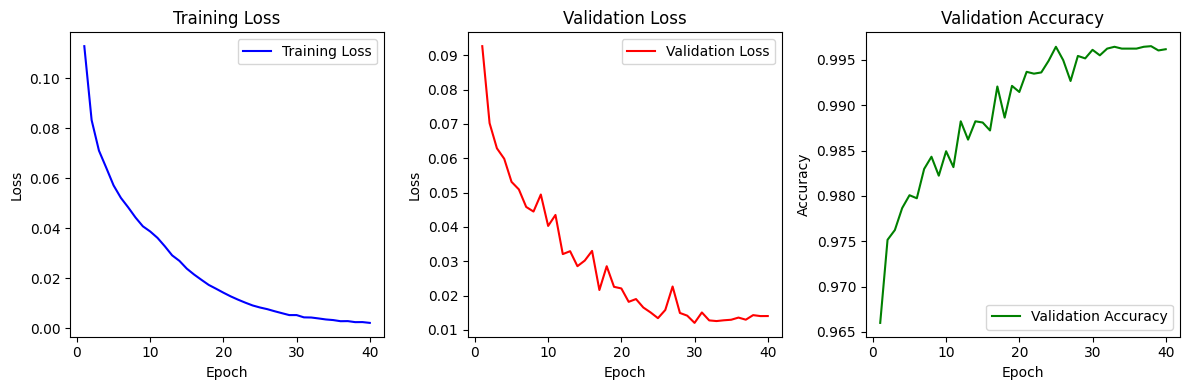

In [17]:
from utils import plot_training_results

plot_training_results(lstm_train_losses, lstm_val_losses, lstm_val_accuracies)

In [18]:
test_model(lstm_model, test_loader)

Test Accuracy: 0.9972


In [24]:
torch.save(lstm_model.state_dict(), "./model/lstm_model.pth")

In [13]:
from torch.utils.data import DataLoader
import torch.optim as optim

x_data_no_conf, y_data_no_conf = preprocess_sequences(all_data_np, sequence_length=10, stride=1, use_conf=False)
train_set_no_conf, val_set_no_conf, test_set_no_conf = split_dataset(x_data_no_conf, y_data_no_conf)

batch_size = 128

train_loader_no_conf = DataLoader(train_set_no_conf, batch_size, shuffle=True)
val_loader_no_conf = DataLoader(val_set_no_conf, batch_size)
test_loader_no_conf = DataLoader(test_set_no_conf, batch_size)

print(x_data_no_conf.shape)

C:\Users\sonnpm\AppData\Local\Temp\ipykernel_55796\894757442.py:63: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  x_tensor = torch.tensor(sequences, dtype=torch.float32)  # (num_seq, seq_len, feature_dim)


torch.Size([450841, 10, 34])


In [14]:
from utils import scheduler
from sequence_model import LSTM_Model
import torch.nn as nn

lstm_model_no_conf = LSTM_Model(input_dim=34)
lstm_model_no_conf_criterion = nn.CrossEntropyLoss()
lstm_model_no_conf_optimizer = torch.optim.Adam(lstm_model_no_conf.parameters(), lr=1e-3, weight_decay=1e-5)

lstm_model_no_conf, lstm_train_losses, lstm_val_losses, lstm_val_accuracies = train_model(
    model=lstm_model_no_conf,
    criterion=lstm_model_no_conf_criterion,
    optimizer=lstm_model_no_conf_optimizer,
    epochs=200,
    train_loader=train_loader_no_conf,
    val_loader=val_loader_no_conf,
    scheduler=scheduler,
    patience=5
)

Using device: cuda
Start training model: LSTM_Model


Epoch [1/200]: 100%|██████████| 2818/2818 [00:14<00:00, 199.15it/s, loss=0.481]


Epoch 1: Train Loss=0.4712, Val Loss=0.3900, Val Acc=0.8183


Epoch [2/200]: 100%|██████████| 2818/2818 [00:14<00:00, 195.47it/s, loss=0.433]


Epoch 2: Train Loss=0.3639, Val Loss=0.3351, Val Acc=0.8480


Epoch [3/200]: 100%|██████████| 2818/2818 [00:14<00:00, 200.37it/s, loss=0.322]


Epoch 3: Train Loss=0.3136, Val Loss=0.2950, Val Acc=0.8694


Epoch [4/200]: 100%|██████████| 2818/2818 [00:13<00:00, 202.77it/s, loss=0.312]


Epoch 4: Train Loss=0.2741, Val Loss=0.2605, Val Acc=0.8872


Epoch [5/200]: 100%|██████████| 2818/2818 [00:13<00:00, 211.03it/s, loss=0.218] 


Epoch 5: Train Loss=0.2433, Val Loss=0.2306, Val Acc=0.9009


Epoch [6/200]: 100%|██████████| 2818/2818 [00:13<00:00, 213.51it/s, loss=0.216] 


Epoch 6: Train Loss=0.2172, Val Loss=0.2159, Val Acc=0.9095


Epoch [7/200]: 100%|██████████| 2818/2818 [00:13<00:00, 208.44it/s, loss=0.243] 


Epoch 7: Train Loss=0.1979, Val Loss=0.1960, Val Acc=0.9188


Epoch [8/200]: 100%|██████████| 2818/2818 [00:14<00:00, 194.11it/s, loss=0.195] 


Epoch 8: Train Loss=0.1801, Val Loss=0.1866, Val Acc=0.9228


Epoch [9/200]: 100%|██████████| 2818/2818 [00:16<00:00, 168.92it/s, loss=0.0949]


Epoch 9: Train Loss=0.1681, Val Loss=0.1821, Val Acc=0.9235


Epoch [10/200]: 100%|██████████| 2818/2818 [00:14<00:00, 189.81it/s, loss=0.14]  


Epoch 10: Train Loss=0.1565, Val Loss=0.1724, Val Acc=0.9296


Epoch [11/200]: 100%|██████████| 2818/2818 [00:14<00:00, 197.54it/s, loss=0.154] 


Epoch 11: Train Loss=0.1468, Val Loss=0.1593, Val Acc=0.9355


Epoch [12/200]: 100%|██████████| 2818/2818 [00:13<00:00, 201.86it/s, loss=0.175] 


Epoch 12: Train Loss=0.1341, Val Loss=0.1444, Val Acc=0.9409


Epoch [13/200]: 100%|██████████| 2818/2818 [00:13<00:00, 203.50it/s, loss=0.133] 


Epoch 13: Train Loss=0.1247, Val Loss=0.1320, Val Acc=0.9455


Epoch [14/200]: 100%|██████████| 2818/2818 [00:14<00:00, 189.56it/s, loss=0.12]  


Epoch 14: Train Loss=0.1145, Val Loss=0.1225, Val Acc=0.9513


Epoch [15/200]: 100%|██████████| 2818/2818 [00:13<00:00, 202.36it/s, loss=0.105] 


Epoch 15: Train Loss=0.1060, Val Loss=0.1204, Val Acc=0.9520


Epoch [16/200]: 100%|██████████| 2818/2818 [00:14<00:00, 193.72it/s, loss=0.13]  


Epoch 16: Train Loss=0.0988, Val Loss=0.1124, Val Acc=0.9552


Epoch [17/200]: 100%|██████████| 2818/2818 [00:14<00:00, 191.61it/s, loss=0.152] 


Epoch 17: Train Loss=0.0927, Val Loss=0.1130, Val Acc=0.9553


Epoch [18/200]: 100%|██████████| 2818/2818 [00:14<00:00, 193.53it/s, loss=0.0589]


Epoch 18: Train Loss=0.0866, Val Loss=0.1000, Val Acc=0.9614


Epoch [19/200]: 100%|██████████| 2818/2818 [00:14<00:00, 195.45it/s, loss=0.076] 


Epoch 19: Train Loss=0.0819, Val Loss=0.0976, Val Acc=0.9622


Epoch [20/200]: 100%|██████████| 2818/2818 [00:14<00:00, 194.08it/s, loss=0.04]  


Epoch 20: Train Loss=0.0772, Val Loss=0.0987, Val Acc=0.9620


Epoch [21/200]: 100%|██████████| 2818/2818 [00:16<00:00, 174.23it/s, loss=0.0168]


Epoch 21: Train Loss=0.0734, Val Loss=0.0949, Val Acc=0.9624


Epoch [22/200]: 100%|██████████| 2818/2818 [00:14<00:00, 192.76it/s, loss=0.109] 


Epoch 22: Train Loss=0.0697, Val Loss=0.0908, Val Acc=0.9648


Epoch [23/200]: 100%|██████████| 2818/2818 [00:14<00:00, 196.16it/s, loss=0.0575]


Epoch 23: Train Loss=0.0663, Val Loss=0.0930, Val Acc=0.9649


Epoch [24/200]: 100%|██████████| 2818/2818 [00:14<00:00, 195.67it/s, loss=0.0514]


Epoch 24: Train Loss=0.0640, Val Loss=0.0880, Val Acc=0.9663


Epoch [25/200]: 100%|██████████| 2818/2818 [00:14<00:00, 199.39it/s, loss=0.0225] 


Epoch 25: Train Loss=0.0608, Val Loss=0.0860, Val Acc=0.9675


Epoch [26/200]: 100%|██████████| 2818/2818 [00:14<00:00, 196.10it/s, loss=0.0171] 


Epoch 26: Train Loss=0.0588, Val Loss=0.0840, Val Acc=0.9680


Epoch [27/200]: 100%|██████████| 2818/2818 [00:14<00:00, 200.28it/s, loss=0.0376]


Epoch 27: Train Loss=0.0566, Val Loss=0.0816, Val Acc=0.9687


Epoch [28/200]: 100%|██████████| 2818/2818 [00:13<00:00, 211.81it/s, loss=0.0257]


Epoch 28: Train Loss=0.0547, Val Loss=0.0815, Val Acc=0.9697


Epoch [29/200]: 100%|██████████| 2818/2818 [00:14<00:00, 197.57it/s, loss=0.0425] 


Epoch 29: Train Loss=0.0529, Val Loss=0.0818, Val Acc=0.9689


Epoch [30/200]: 100%|██████████| 2818/2818 [00:14<00:00, 192.93it/s, loss=0.075]  


Epoch 30: Train Loss=0.0512, Val Loss=0.0800, Val Acc=0.9706


Epoch [31/200]: 100%|██████████| 2818/2818 [00:14<00:00, 189.62it/s, loss=0.0954] 


Epoch 31: Train Loss=0.0500, Val Loss=0.0777, Val Acc=0.9713


Epoch [32/200]: 100%|██████████| 2818/2818 [00:14<00:00, 193.70it/s, loss=0.0655] 


Epoch 32: Train Loss=0.0488, Val Loss=0.0779, Val Acc=0.9713


Epoch [33/200]: 100%|██████████| 2818/2818 [00:14<00:00, 194.98it/s, loss=0.0797] 


Epoch 33: Train Loss=0.0477, Val Loss=0.0773, Val Acc=0.9716


Epoch [34/200]: 100%|██████████| 2818/2818 [00:14<00:00, 196.29it/s, loss=0.0493] 


Epoch 34: Train Loss=0.0467, Val Loss=0.0790, Val Acc=0.9713


Epoch [35/200]: 100%|██████████| 2818/2818 [00:14<00:00, 192.18it/s, loss=0.0916] 


Epoch 35: Train Loss=0.0458, Val Loss=0.0754, Val Acc=0.9727


Epoch [36/200]: 100%|██████████| 2818/2818 [00:14<00:00, 199.14it/s, loss=0.0217] 


Epoch 36: Train Loss=0.0448, Val Loss=0.0763, Val Acc=0.9721


Epoch [37/200]: 100%|██████████| 2818/2818 [00:14<00:00, 194.53it/s, loss=0.0494] 


Epoch 37: Train Loss=0.0441, Val Loss=0.0757, Val Acc=0.9724


Epoch [38/200]: 100%|██████████| 2818/2818 [00:14<00:00, 198.26it/s, loss=0.0464] 


Epoch 38: Train Loss=0.0436, Val Loss=0.0764, Val Acc=0.9720


Epoch [39/200]: 100%|██████████| 2818/2818 [00:14<00:00, 197.10it/s, loss=0.0175] 


Epoch 39: Train Loss=0.0431, Val Loss=0.0754, Val Acc=0.9724


Epoch [40/200]: 100%|██████████| 2818/2818 [00:14<00:00, 189.92it/s, loss=0.0718] 


Epoch 40: Train Loss=0.0425, Val Loss=0.0755, Val Acc=0.9727
Early stopping triggered after 40 epochs
Finish training model: LSTM_Model


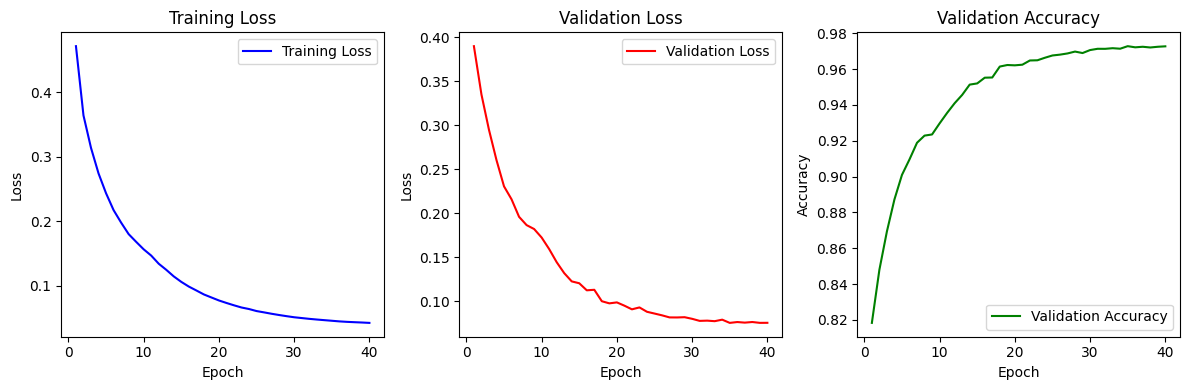

In [18]:
from utils import plot_training_results

plot_training_results(lstm_train_losses, lstm_val_losses, lstm_val_accuracies)

In [17]:
torch.save(lstm_model_no_conf.state_dict(), "./model/lstm_model_no_conf.pth")

In [21]:
test_model(lstm_model_no_conf, test_loader_no_conf)

Test Accuracy: 0.9716


In [20]:
from utils import scheduler
from sequence_model import LSTM_Model_2
import torch.nn as nn

lstm_model_no_conf2 = LSTM_Model_2(input_dim=34)
lstm_model_no_conf2_criterion = nn.CrossEntropyLoss()
lstm_model_no_conf2_optimizer = torch.optim.Adam(lstm_model_no_conf2.parameters(), lr=1e-3, weight_decay=1e-5)

lstm_model_no_conf2, lstm_train_losses, lstm_val_losses, lstm_val_accuracies = train_model(
    model=lstm_model_no_conf2,
    criterion=lstm_model_no_conf2_criterion,
    optimizer=lstm_model_no_conf2_optimizer,
    epochs=200,
    train_loader=train_loader_no_conf,
    val_loader=val_loader_no_conf,
    scheduler=scheduler,
    patience=10
)

Using device: cuda
Start training model: LSTM_Model_2


Epoch [1/200]: 100%|██████████| 2818/2818 [00:16<00:00, 173.81it/s, loss=0.403]


Epoch 1: Train Loss=0.4743, Val Loss=0.3972, Val Acc=0.8139


Epoch [2/200]: 100%|██████████| 2818/2818 [00:15<00:00, 187.44it/s, loss=0.227]


Epoch 2: Train Loss=0.3461, Val Loss=0.2915, Val Acc=0.8710


Epoch [3/200]: 100%|██████████| 2818/2818 [00:15<00:00, 186.13it/s, loss=0.267]


Epoch 3: Train Loss=0.2667, Val Loss=0.2356, Val Acc=0.8974


Epoch [4/200]: 100%|██████████| 2818/2818 [00:15<00:00, 181.35it/s, loss=0.22]  


Epoch 4: Train Loss=0.2280, Val Loss=0.2109, Val Acc=0.9113


Epoch [5/200]: 100%|██████████| 2818/2818 [00:15<00:00, 183.36it/s, loss=0.148] 


Epoch 5: Train Loss=0.2019, Val Loss=0.1960, Val Acc=0.9186


Epoch [6/200]: 100%|██████████| 2818/2818 [00:15<00:00, 178.18it/s, loss=0.172] 


Epoch 6: Train Loss=0.1825, Val Loss=0.1722, Val Acc=0.9276


Epoch [7/200]: 100%|██████████| 2818/2818 [00:15<00:00, 180.00it/s, loss=0.171] 


Epoch 7: Train Loss=0.1658, Val Loss=0.1673, Val Acc=0.9297


Epoch [8/200]: 100%|██████████| 2818/2818 [00:15<00:00, 187.09it/s, loss=0.0977]


Epoch 8: Train Loss=0.1523, Val Loss=0.1488, Val Acc=0.9389


Epoch [9/200]: 100%|██████████| 2818/2818 [00:15<00:00, 182.33it/s, loss=0.0649]


Epoch 9: Train Loss=0.1409, Val Loss=0.1550, Val Acc=0.9379


Epoch [10/200]: 100%|██████████| 2818/2818 [00:15<00:00, 180.73it/s, loss=0.0991]


Epoch 10: Train Loss=0.1324, Val Loss=0.1377, Val Acc=0.9439


Epoch [11/200]: 100%|██████████| 2818/2818 [00:15<00:00, 183.84it/s, loss=0.193] 


Epoch 11: Train Loss=0.1245, Val Loss=0.1438, Val Acc=0.9403


Epoch [12/200]: 100%|██████████| 2818/2818 [00:15<00:00, 186.75it/s, loss=0.152] 


Epoch 12: Train Loss=0.1124, Val Loss=0.1251, Val Acc=0.9490


Epoch [13/200]: 100%|██████████| 2818/2818 [00:15<00:00, 182.59it/s, loss=0.152] 


Epoch 13: Train Loss=0.1022, Val Loss=0.1151, Val Acc=0.9545


Epoch [14/200]: 100%|██████████| 2818/2818 [00:15<00:00, 186.06it/s, loss=0.127] 


Epoch 14: Train Loss=0.0939, Val Loss=0.1098, Val Acc=0.9568


Epoch [15/200]: 100%|██████████| 2818/2818 [00:15<00:00, 182.88it/s, loss=0.0293]


Epoch 15: Train Loss=0.0862, Val Loss=0.0953, Val Acc=0.9627


Epoch [16/200]: 100%|██████████| 2818/2818 [00:15<00:00, 185.31it/s, loss=0.102] 


Epoch 16: Train Loss=0.0791, Val Loss=0.0969, Val Acc=0.9619


Epoch [17/200]: 100%|██████████| 2818/2818 [00:15<00:00, 185.81it/s, loss=0.0644]


Epoch 17: Train Loss=0.0737, Val Loss=0.0944, Val Acc=0.9638


Epoch [18/200]: 100%|██████████| 2818/2818 [00:15<00:00, 185.51it/s, loss=0.0506]


Epoch 18: Train Loss=0.0678, Val Loss=0.0898, Val Acc=0.9665


Epoch [19/200]: 100%|██████████| 2818/2818 [00:15<00:00, 176.47it/s, loss=0.0625] 


Epoch 19: Train Loss=0.0636, Val Loss=0.0851, Val Acc=0.9682


Epoch [20/200]: 100%|██████████| 2818/2818 [00:15<00:00, 187.29it/s, loss=0.0422] 


Epoch 20: Train Loss=0.0598, Val Loss=0.0880, Val Acc=0.9669


Epoch [21/200]: 100%|██████████| 2818/2818 [00:15<00:00, 183.01it/s, loss=0.0549] 


Epoch 21: Train Loss=0.0557, Val Loss=0.0833, Val Acc=0.9685


Epoch [22/200]: 100%|██████████| 2818/2818 [00:15<00:00, 183.16it/s, loss=0.0535] 


Epoch 22: Train Loss=0.0527, Val Loss=0.0904, Val Acc=0.9683


Epoch [23/200]: 100%|██████████| 2818/2818 [00:14<00:00, 188.08it/s, loss=0.0549] 


Epoch 23: Train Loss=0.0501, Val Loss=0.0788, Val Acc=0.9724


Epoch [24/200]: 100%|██████████| 2818/2818 [00:14<00:00, 188.02it/s, loss=0.0544] 


Epoch 24: Train Loss=0.0475, Val Loss=0.0898, Val Acc=0.9685


Epoch [25/200]: 100%|██████████| 2818/2818 [00:15<00:00, 184.96it/s, loss=0.0698] 


Epoch 25: Train Loss=0.0453, Val Loss=0.0802, Val Acc=0.9728


Epoch [26/200]: 100%|██████████| 2818/2818 [00:14<00:00, 188.71it/s, loss=0.00912]


Epoch 26: Train Loss=0.0433, Val Loss=0.0874, Val Acc=0.9704


Epoch [27/200]: 100%|██████████| 2818/2818 [00:15<00:00, 186.69it/s, loss=0.0499] 


Epoch 27: Train Loss=0.0416, Val Loss=0.0785, Val Acc=0.9738


Epoch [28/200]: 100%|██████████| 2818/2818 [00:15<00:00, 183.61it/s, loss=0.0346] 


Epoch 28: Train Loss=0.0400, Val Loss=0.0805, Val Acc=0.9747


Epoch [29/200]: 100%|██████████| 2818/2818 [00:15<00:00, 181.65it/s, loss=0.0315]  


Epoch 29: Train Loss=0.0388, Val Loss=0.0793, Val Acc=0.9750


Epoch [30/200]: 100%|██████████| 2818/2818 [00:15<00:00, 184.11it/s, loss=0.0277] 


Epoch 30: Train Loss=0.0374, Val Loss=0.0785, Val Acc=0.9753


Epoch [31/200]: 100%|██████████| 2818/2818 [00:15<00:00, 186.33it/s, loss=0.0496] 


Epoch 31: Train Loss=0.0360, Val Loss=0.0806, Val Acc=0.9762


Epoch [32/200]: 100%|██████████| 2818/2818 [00:15<00:00, 186.78it/s, loss=0.0112] 


Epoch 32: Train Loss=0.0351, Val Loss=0.0849, Val Acc=0.9755


Epoch [33/200]: 100%|██████████| 2818/2818 [00:14<00:00, 192.40it/s, loss=0.092]  


Epoch 33: Train Loss=0.0341, Val Loss=0.0915, Val Acc=0.9740


Epoch [34/200]: 100%|██████████| 2818/2818 [00:14<00:00, 199.71it/s, loss=0.0547] 


Epoch 34: Train Loss=0.0333, Val Loss=0.0841, Val Acc=0.9764


Epoch [35/200]: 100%|██████████| 2818/2818 [00:15<00:00, 183.73it/s, loss=0.0648] 


Epoch 35: Train Loss=0.0326, Val Loss=0.0859, Val Acc=0.9762


Epoch [36/200]: 100%|██████████| 2818/2818 [00:15<00:00, 182.08it/s, loss=0.0126] 


Epoch 36: Train Loss=0.0318, Val Loss=0.0873, Val Acc=0.9760


Epoch [37/200]: 100%|██████████| 2818/2818 [00:15<00:00, 176.16it/s, loss=0.00732] 


Epoch 37: Train Loss=0.0313, Val Loss=0.0856, Val Acc=0.9765
Early stopping triggered after 37 epochs
Finish training model: LSTM_Model_2


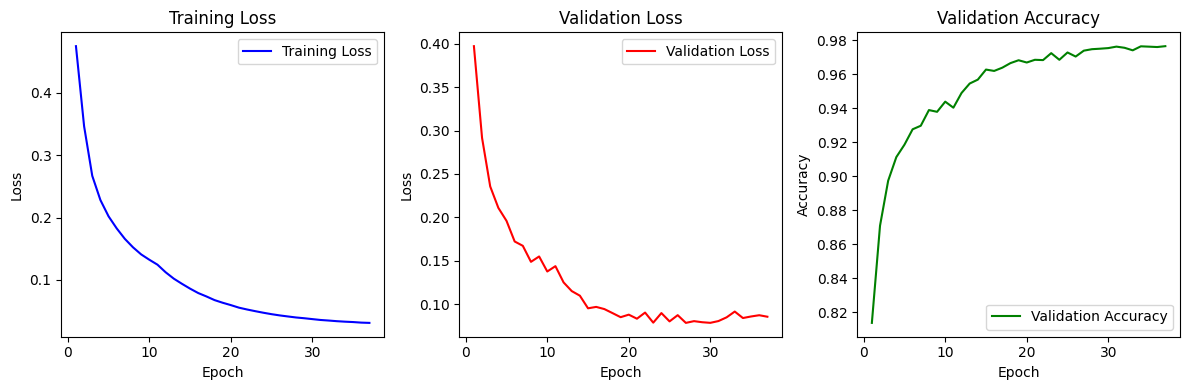

In [22]:
from utils import plot_training_results

plot_training_results(lstm_train_losses, lstm_val_losses, lstm_val_accuracies)

In [23]:
torch.save(lstm_model_no_conf2.state_dict(), "./model/lstm_model_no_conf2.pth")
test_model(lstm_model_no_conf2, test_loader_no_conf)

Test Accuracy: 0.9762
